In [1]:
import sys

sys.path.insert(0, '/gpfs/space/home/dzvenymy/SwinIA-segmentation/')

In [2]:
import pandas as pd

In [3]:
import os
import cv2
import torch
import einops
import numpy as np
from pathlib import Path
from noise2same.backbone import swinia, unet, unet_b2u
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from noise2same import util
from noise2same.dataset.getter import expand_dataset_cfg
from importlib import reload
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Tuple
from noise2same.util import crop_as

In [4]:
from sklearn.cluster import KMeans, DBSCAN
from skimage.filters import threshold_otsu

In [5]:
util.register_config_resolvers()

In [6]:
swinia = reload(swinia)

In [7]:
path = '/gpfs/space/projects/transformers_uss/'

In [8]:

cfg = OmegaConf.load('../config_seg/config_full_livecell.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)

expand_dataset_cfg(cfg)
data = instantiate(cfg.dataset_test)

loading annotations into memory...
Done (t=3.61s)
creating index...
index created!


100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


(500, 520, 704)


In [9]:
# cf_mice
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-15_20-23-08_SSFJW/'
# tp_mice
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-16_15-09-54_NZZIB/'
# cf_fish
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-16_11-04-57_ZRHCV/'
# synthetic
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/synthetic/swinia/train/2023-11-17_13-00-36_QJDGV/'

path = '/gpfs/space/projects/transformers_uss/'

cfg = OmegaConf.load('../config_seg/config_full_livecell.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)
backbone = instantiate(cfg.backbone)
head = instantiate(cfg.head)
denoiser = instantiate(cfg.denoiser, backbone=backbone, head=head)

checkpoint = torch.load(path + 'tp_mice.pth')['model']

denoiser.load_state_dict(checkpoint)
denoiser.to('cuda')
print(torch.cuda.memory_allocated(0))


53389312


In [10]:
cfg = OmegaConf.load('../config_seg/config_full_livecell_noise2same.yaml')
# cfg.cwd = Path(os.getcwd())
# OmegaConf.resolve(cfg)
backbone = instantiate(cfg.backbone)
head = instantiate(cfg.head)
noise2same = instantiate(cfg.denoiser, backbone=backbone, head=head)

checkpoint = torch.load(path + 'noise2same.pth')['model']

noise2same.load_state_dict(checkpoint, strict=False)
noise2same.to('cuda')
print(torch.cuda.memory_allocated(0))

72844800


In [16]:
# to get feature map comment line 418 in noise2same/backbone/swinia.py
# channel first
index = 309
denoiser.eval()
with torch.no_grad():
    result = denoiser(data[index]['image'].unsqueeze(0).cuda())['image'].detach().cpu().numpy()
    

In [8]:
from sklearn.metrics import f1_score, accuracy_score, precision_score


def accuracy_seg(pred_mask, gt_mask):
    return np.max([accuracy_score(gt_mask.flatten(), pred_mask.flatten()), accuracy_score(gt_mask.flatten(), 1 - pred_mask.flatten())])


def precision_seg(pred_mask, gt_mask):
    return np.max([precision_score(gt_mask.flatten(), pred_mask.flatten()), precision_score(gt_mask.flatten(), 1 - pred_mask.flatten())])


def get_seg_masks(batch): # ToDO: batch size is 1, extend to batch size > 1
    feature_map = batch['image'][0].transpose(1,2,0).reshape(-1, batch['shape'][0])
    k_means = KMeans(n_clusters=2)
    k_means.fit(feature_map)
    out = k_means.predict(feature_map)
    out = out.reshape(batch['shape'][1:])
    return out


def f1_score_seg(pred_mask, gt_mask):
    return np.max([f1_score(gt_mask.flatten(), pred_mask.flatten()), f1_score(gt_mask.flatten(), 1 - pred_mask.flatten())])


def iou(pred_mask, gt_mask):
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Input masks must have the same shape")

    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)

    if np.sum(union) == 0:
        iou_0 =  0.0
    else:
        iou_0 = np.sum(intersection) / np.sum(union)

    intersection = np.logical_and(gt_mask, 1 - pred_mask)
    union = np.logical_or(gt_mask, 1 - pred_mask)

    if np.sum(union) == 0:
        iou_1 = 0.0
    else:
        iou_1 = np.sum(intersection) / np.sum(union)

    return np.max([iou_0, iou_1])


def seg_scores(pred_mask, gt_mask, prefix='seg_'):
    metrics_fn = {'accuracy': accuracy_seg, 'precision': precision_seg, 'f1': f1_score_seg, 'iou': iou}
    scores = {prefix + metric: metrics_fn[metric](pred_mask, gt_mask) for metric in metrics_fn.keys()}
    return scores


In [23]:
# Run otsu filteing on whole data

all_metrics_otsu = []
for index in range(len(data)):
    vectorized_orig = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
    vectorized_orig = crop_as(vectorized_orig, (1, 520, 704))

    thresh = threshold_otsu(vectorized_orig[0])
    binary = vectorized_orig > thresh
    gt_mask = data[index]['gt_mask']
    scores = seg_scores(binary[0], gt_mask[:, :, 0])
    
    all_metrics_otsu.append(scores)

In [16]:
all_metrics_otsu

[{'seg_accuracy': 0.7654173951048951,
  'seg_precision': 0.7220915755982847,
  'seg_f1': 0.36879617949180027,
  'seg_iou': 0.2260883495092001}]

In [28]:
d  = {k:[] for k in all_metrics_otsu[0].keys()}
for k in d.keys():
    for dd in all_metrics_otsu:
        d[k].append(dd[k])
all_metrics_otsu_df = pd.DataFrame(d)
all_metrics_otsu_df.head()

seg_accuracy  seg_precision    seg_f1   seg_iou
0      0.765417       0.722092  0.368796  0.226088
1      0.694772       0.792788  0.457922  0.296951
2      0.713604       0.815655  0.437522  0.280018
3      0.816761       0.840063  0.303508  0.178903
4      0.833610       0.859965  0.280458  0.163100

In [29]:
all_metrics_otsu_df.to_csv('/gpfs/space/projects/transformers_uss/seg_experiments/fmd_mice_livecell_test_random_500/evaluate/2024-01-23_06-43-24/scores_otsu.csv')

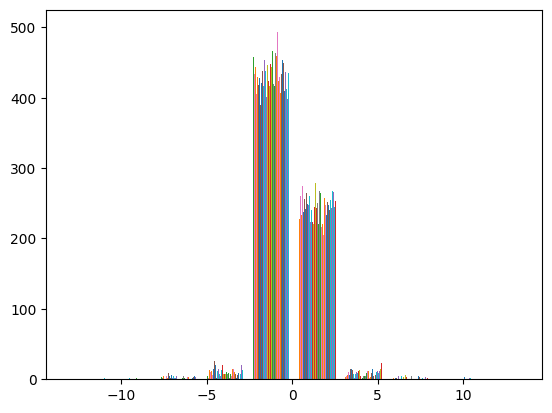

In [40]:
plt.hist(data[index]['image'][0])
plt.show()

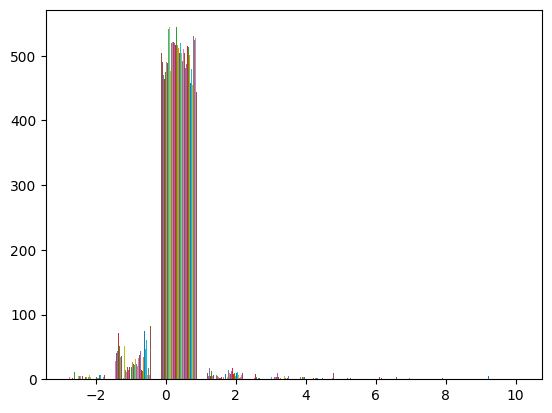

In [39]:
plt.hist(result[0][0])
plt.show()

(<Axes: >, <matplotlib.image.AxesImage at 0x2ae9e4f68f70>)

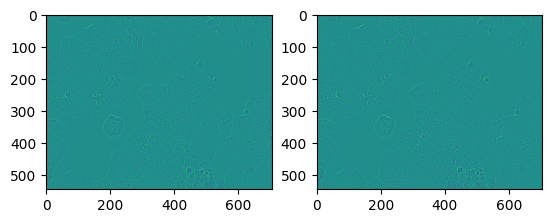

In [18]:
plt.subplot(1,2,1),plt.imshow(data[index]['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2),plt.imshow(norm_img.numpy().transpose(1, 2, 0))

(<Axes: >, <matplotlib.image.AxesImage at 0x2aebe36e9ab0>)

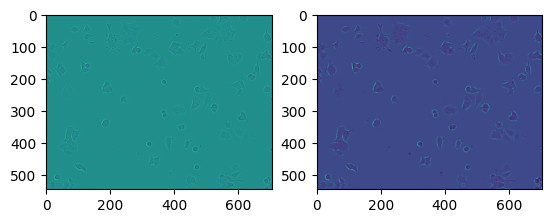

In [38]:
plt.subplot(1,2,1),plt.imshow(data[index]['image'].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2), plt.imshow(result[0].transpose(1, 2, 0))

In [12]:
result.shape

torch.Size([1, 144, 544, 704])

In [17]:
result[0].shape

torch.Size([144, 544, 704])

In [17]:
vectorized_orig = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
target_shape = data[index]['shape']
target_shape = [520, 704, 144]
# target_shape[-1] = 144

feature_map = result[0].transpose(1,2,0)
feature_map = crop_as(feature_map, target_shape)
vectorized_swinia = feature_map.reshape(-1, 144)
vectorized_heads = np.split(vectorized_swinia, 16, axis=-1)

In [55]:
vectorized_swinia.shape, feature_map.shape

((366080, 144), (520, 704, 144))

In [ ]:
# cf_mice
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_23-46-28/'
# tp_mice
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_23-52-39/'
# cf_fish
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_19-59-25/'
# synthetic
path = '/gpfs/space/home/papkov/swinia/results/synthetic/unet/train/2023-03-04_19-51-14/'

cfg = OmegaConf.load(path + '.hydra/config.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)
backbone = unet.UNet(in_channels=cfg.data.n_channels, **cfg.backbone)

checkpoint = torch.load(path + 'checkpoints/model_last.pth')['model']
weights = dict()
for key in checkpoint:
    if key.startswith('net.'):
        weights[key.replace('net.', '')] = checkpoint[key]
backbone.load_state_dict(weights)
backbone.to('cuda')
target_shape[-1] = 96

image = (data[index]['image'] * data[index]['std'] + data[index]['mean'])
image = (image - image.mean()) / image.std()
backbone.eval()
with torch.no_grad():
    result = backbone(data[index]['image'].unsqueeze(0).cuda())

feature_map = result.detach().cpu().numpy()
feature_map = crop_as(feature_map.transpose(0, 2, 3, 1)[0], target_shape)
vectorized_n2s = feature_map.reshape(-1, 96)

In [ ]:
# cf_mice
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/Confocal_MICE_112rf20_beta19.7.pth'
# tp_mice
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/TwoPhoton_MICE_112rf20_beta20.pth'
# cf_fish
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/Confocal_FISH_112rf20_beta20.pth'
# synthetic
path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/g25_112f20_beta19.7.pth'

checkpoint = torch.load(path)
del checkpoint['last.2.weight']
del checkpoint['last.2.bias']
model = unet_b2u.UNetB2UReal(cfg.data.n_channels, cfg.data.n_channels)
model.load_state_dict(checkpoint)
model.to('cuda')
target_shape[-1] = 96

image = (data[index]['image'] * data[index]['std'] + data[index]['mean']) / 255
model.eval()
with torch.no_grad():
    result = model(image.unsqueeze(0).cuda())

feature_map = result.detach().cpu().numpy()
feature_map = crop_as(feature_map.transpose(0, 2, 3, 1)[0], target_shape)
vectorized_b2u = feature_map.reshape(-1, 96)

In [19]:
thresh = threshold_otsu(vectorized_orig[0])
binary = vectorized_orig > thresh

In [ ]:
np.random.seed(111)
dbscan = DBSCAN(eps=1)
res = dbscan.fit_predict(vectorized_swinia)
result_swinia_dbscan = res.reshape(target_shape[:2])

In [20]:
np.random.seed(111)
k = 2
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_swinia)
res = k_means.predict(vectorized_swinia)
result_swinia = res.reshape(target_shape[:2])

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
res.shape

(366080,)

In [14]:
np.unique(result_swinia)

array([0, 1], dtype=int32)

In [ ]:
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_n2s)
res = k_means.predict(vectorized_n2s)
result_n2s = res.reshape(target_shape[:2])

In [ ]:
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_b2u)
res = k_means.predict(vectorized_b2u)
result_b2u = res.reshape(target_shape[:2])

In [ ]:
n2s_0 = np.where(result_n2s == 0)
n2s_1 = np.where(result_n2s == 1)
n2s_2 = np.where(result_n2s == 2)
n2s_3 = np.where(result_n2s == 3)

b2u_0 = np.where(result_b2u == 0)
b2u_1 = np.where(result_b2u == 1)
b2u_2 = np.where(result_b2u == 2)
b2u_3 = np.where(result_b2u == 3)

swin_0 = np.where(result_swinia == 0)
swin_1 = np.where(result_swinia == 1)
swin_2 = np.where(result_swinia == 2)
swin_3 = np.where(result_swinia == 3)

result_n2s_ = result_n2s.copy()
result_n2s_[n2s_0] = 2
result_n2s_[n2s_2] = 0

result_b2u_ = result_b2u.copy()
result_b2u_[b2u_2] = 0
result_b2u_[b2u_1] = 2
result_b2u_[b2u_0] = 1

result_swinia_ = result_swinia.copy()
result_swinia_[swin_2] = 3
result_swinia_[swin_1] = 2
result_swinia_[swin_3] = 1

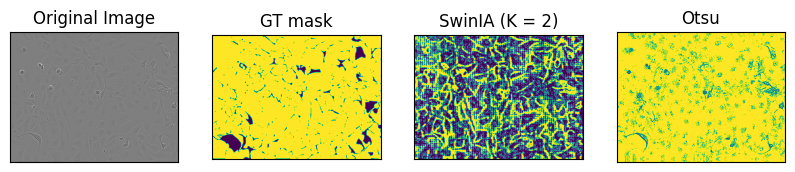

In [23]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10

figure_size = 10
plt.figure(figsize=(figure_size,figure_size))
#original image
plt.subplot(1,4,1),plt.imshow(vectorized_orig.transpose(1, 2, 0), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#image 2
# plt.subplot(1,5,2),plt.imshow(binary.transpose(1, 2, 0).astype(int))
# plt.title('Original (Otsu)'), plt.xticks([]), plt.yticks([])
#image 3
# plt.subplot(1,5,3),plt.imshow(result_n2s)
# plt.title('Noise2Same (K = 4)'), plt.xticks([]), plt.yticks([])

# plt.subplot(1,5,4),plt.imshow(result_b2u)
# plt.title('B2U (K = 4)'), plt.xticks([]), plt.yticks([])

plt.subplot(1,4,2),plt.imshow(data[index]['gt_mask'] )
plt.title('GT mask'), plt.xticks([]), plt.yticks([]);

plt.subplot(1,4,3), plt.imshow((1-result_swinia).astype(np.uint8))
plt.title('SwinIA (K = 2)'), plt.xticks([]), plt.yticks([]);

plt.subplot(1,4,4), plt.imshow(binary[0])
plt.title('Otsu'), plt.xticks([]), plt.yticks([]);

In [36]:
def show_res(index):
    with torch.no_grad():
        result = denoiser(data[index]['image'].unsqueeze(0).cuda())['image'].detach().cpu().numpy()
    vectorized_orig = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
    target_shape = data[index]['shape']
    target_shape = [520, 704, 144]
    # target_shape[-1] = 144

    feature_map = result[0].transpose(1,2,0)
    feature_map = crop_as(feature_map, target_shape)
    vectorized_swinia = feature_map.reshape(-1, 144)
    vectorized_heads = np.split(vectorized_swinia, 16, axis=-1)

    np.random.seed(111)
    k = 2
    k_means = KMeans(n_clusters=k)
    k_means.fit(vectorized_swinia)
    res = k_means.predict(vectorized_swinia)
    result_swinia = res.reshape(target_shape[:2])
    
    
    thresh = threshold_otsu(vectorized_orig[0])
    binary = vectorized_orig > thresh

    figure_size = 10
    plt.figure(figsize=(figure_size,figure_size))
    #original image
    plt.subplot(1,4,1),plt.imshow(vectorized_orig.transpose(1, 2, 0), cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    #image 2
    # plt.subplot(1,5,2),plt.imshow(binary.transpose(1, 2, 0).astype(int))
    # plt.title('Original (Otsu)'), plt.xticks([]), plt.yticks([])
    #image 3
    # plt.subplot(1,5,3),plt.imshow(result_n2s)
    # plt.title('Noise2Same (K = 4)'), plt.xticks([]), plt.yticks([])

    # plt.subplot(1,5,4),plt.imshow(result_b2u)
    # plt.title('B2U (K = 4)'), plt.xticks([]), plt.yticks([])

    plt.subplot(1,4,2),plt.imshow(data[index]['gt_mask'] )
    plt.title('GT mask'), plt.xticks([]), plt.yticks([]);

    plt.subplot(1,4,3), plt.imshow((1-result_swinia).astype(np.uint8))
    plt.title('SwinIA (K = 2)'), plt.xticks([]), plt.yticks([]);

    plt.subplot(1,4,4), plt.imshow(binary[0])
    plt.title('Otsu'), plt.xticks([]), plt.yticks([]);

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


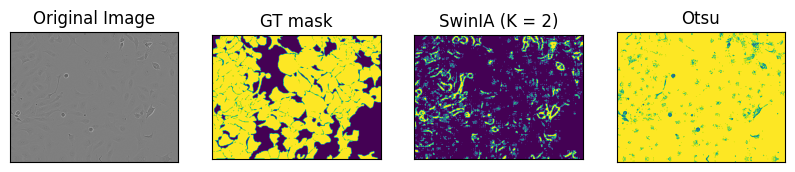

In [37]:
show_res(289) # Skov3

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


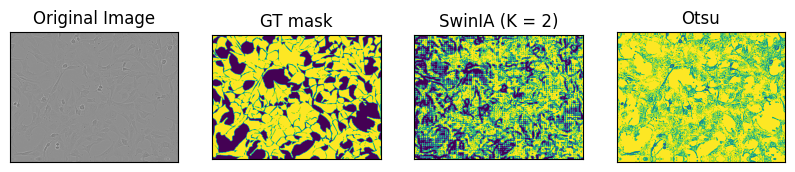

In [38]:
show_res(60) # A172 (brain)

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


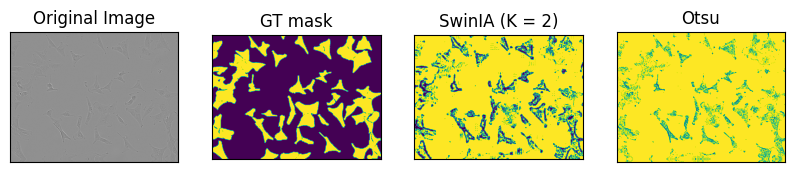

In [39]:
show_res(52) # A172 (brain)

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
f

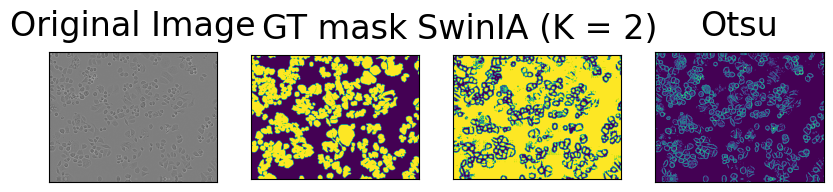

In [102]:
show_res(278) #SkBr3

In [15]:
def iou(mask1, mask2):
    # Ensure masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape")

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Calculate IoU only if the union is not empty
    if np.sum(union) == 0:
        return 0.0

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [18]:
data[index]['seg_mask'].shape

(520, 704, 1)

In [26]:
iou(data[index]['seg_mask'], np.expand_dims(1-result_swinia, -1))

0.5227116778138879

In [28]:
iou(data[index]['seg_mask'], crop_as(binary, (1, 520, 704)).transpose(1,2,0))

0.4996773309033904

In [30]:
from sklearn.metrics import f1_score

In [34]:
f1_score(data[index]['seg_mask'].reshape(-1), np.expand_dims(1-result_swinia, -1).reshape(-1))

0.6865537126034649

In [ ]:
vectorized_orig.shape

In [ ]:
result_b2u.shape

In [ ]:
inertia = []
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    k_means = KMeans(n_clusters=k)
    k_means.fit(vectorized_swinia)
    res = k_means.predict(vectorized_swinia)
    result_swinia = res.reshape(target_shape[:2])
    inertia.append(k_means.inertia_)

In [ ]:
plt.plot([2, 3, 4, 5, 6, 7], inertia)

In [ ]:
(vectorized_orig * data[0]['std'] + data[0]['mean']).shape

# Calculate scores by cell type

In [73]:
from pycocotools.coco import COCO
import skimage.io as io

In [74]:
coco=COCO('/gpfs/space/projects/transformers_uss/livecell/annotations/livecell_coco_test_random_500.json')

loading annotations into memory...
Done (t=3.30s)
creating index...
index created!


In [75]:
images = coco.loadImgs(coco.getImgIds())
images[0]

{'id': 103985,
 'width': 704,
 'height': 520,
 'file_name': 'BT474_Phase_D3_2_04d04h00m_2.tif',
 'original_filename': 'BT474_Phase_D3_2_04d04h00m_2.png',
 'url': 'https://darwin.v7labs.com/api/images/61749/original'}

In [76]:
celltypes = {}
for img in images:
    name = img['file_name'].split('_')[0]
    if name not in celltypes:
        celltypes[name] = 1
    else:
        celltypes[name] += 1
    img['celltype'] = name

In [77]:
celltypes

{'BT474': 50,
 'A172': 49,
 'MCF7': 62,
 'Huh7': 65,
 'BV2': 48,
 'SkBr3': 61,
 'SKOV3': 105,
 'SHSY5Y': 60}

In [3]:
scores = pd.read_csv('scores_Swinia.csv')
scores = scores[scores.columns[1:]]
scores_1 = pd.read_csv('scores_otsu.csv')
scores_1 = scores_1[scores_1.columns[1:]]

scores_2 = pd.read_csv('scores.csv')
scores_2 = scores_2[scores_2.columns[1:-1]]




scores = scores.join(scores_1, lsuffix='_swinia', rsuffix='_otsu')
scores = scores.join(scores_2, rsuffix='_noise2same')

scores.head()

seg_accuracy_swinia  seg_precision_swinia  seg_f1_swinia  seg_iou_swinia  \
0             0.741251              0.253907       0.401574        0.251231   
1             0.657127              0.338525       0.504097        0.336985   
2             0.678313              0.316768       0.479584        0.315429   
3             0.786273              0.208176       0.340335        0.205062   
4             0.805155              0.186614       0.313880        0.186155   

                dataset_name  repeat_id  seg_accuracy_otsu  \
0  livecell_test_random_500_          0           0.765417   
1  livecell_test_random_500_          0           0.694772   
2  livecell_test_random_500_          0           0.713604   
3  livecell_test_random_500_          0           0.816761   
4  livecell_test_random_500_          0           0.833610   

   seg_precision_otsu  seg_f1_otsu  seg_iou_otsu  seg_accuracy  seg_precision  \
0            0.722092     0.368796      0.226088      0.720048       0.257925   
1            0.792788     0.457922      0.296951      0.639360       0.339790   
2            0.815655     0.437522      0.280018      0.641111       0.319221   
3            0.840063     0.303508      0.178903      0.781037       0.221636   
4            0.859965     0.280458      0.163100      0.783296       0.187067   

     seg_f1   seg_iou    dataset_name_noise2same  
0  0.397273  0.247873  livecell_test_random_500_  
1  0.496330  0.330079  livecell_test_random_500_  
2  0.471858  0.308779  livecell_test_random_500_  
3  0.339144  0.204198  livecell_test_random_500_  
4  0.312895  0.185462  livecell_test_random_500_

In [4]:
scores = scores.rename(columns={n:n + '_noise2same' for n in ['seg_accuracy', 'seg_precision', 'seg_f1', 'seg_iou']})

In [80]:
scores['cell_type'] = pd.Series([img['celltype'] for img in images])

In [147]:
scores[scores['cell_type'] == 'Huh7'].head(20)

seg_accuracy_swinia  seg_precision_swinia  seg_f1_swinia  seg_iou_swinia  \
161             0.739598              0.253763       0.403690        0.252890   
165             0.741436              0.251837       0.401255        0.250981   
168             0.755553              0.239716       0.382692        0.236623   
194             0.757812              0.234931       0.379496        0.234184   
199             0.548954              0.449828       0.617762        0.446929   
206             0.594315              0.402979       0.572208        0.400764   
215             0.794337              0.199370       0.328801        0.196745   
216             0.880958              0.108209       0.195021        0.108046   
217             0.736541              0.256977       0.407563        0.255936   
218             0.841974              0.151030       0.258067        0.148150   
219             0.757567              0.235116       0.379733        0.234365   
220             0.808777              0.182615       0.308197        0.182171   
221             0.687568              0.307173       0.468476        0.305888   
222             0.802363              0.190107       0.317349        0.188601   
223             0.807181              0.184613       0.311059        0.184174   
224             0.799104              0.192861       0.321951        0.191860   
225             0.686241              0.310219       0.470155        0.307322   
226             0.807772              0.183457       0.309374        0.182993   
227             0.786172              0.206404       0.340624        0.205272   
228             0.849448              0.140867       0.246534        0.140598   

                  dataset_name  repeat_id  seg_accuracy_otsu  \
161  livecell_test_random_500_          0           0.761202   
165  livecell_test_random_500_          0           0.760487   
168  livecell_test_random_500_          0           0.776470   
194  livecell_test_random_500_          0           0.780969   
199  livecell_test_random_500_          0           0.581392   
206  livecell_test_random_500_          0           0.622304   
215  livecell_test_random_500_          0           0.816920   
216  livecell_test_random_500_          0           0.900292   
217  livecell_test_random_500_          0           0.756747   
218  livecell_test_random_500_          0           0.859602   
219  livecell_test_random_500_          0           0.779608   
220  livecell_test_random_500_          0           0.828947   
221  livecell_test_random_500_          0           0.715860   
222  livecell_test_random_500_          0           0.821056   
223  livecell_test_random_500_          0           0.824642   
224  livecell_test_random_500_          0           0.813686   
225  livecell_test_random_500_          0           0.702882   
226  livecell_test_random_500_          0           0.829843   
227  livecell_test_random_500_          0           0.806602   
228  livecell_test_random_500_          0           0.870069   

     seg_precision_otsu  seg_f1_otsu  seg_iou_otsu  seg_accuracy_noise2same  \
161            0.869184     0.382891      0.236775                 0.729616   
165            0.815631     0.382889      0.236774                 0.737098   
168            0.852452     0.362354      0.221265                 0.744512   
194            0.887849     0.356935      0.217237                 0.750590   
199            0.913926     0.588292      0.416723                 0.545064   
206            0.849425     0.544708      0.374295                 0.589625   
215            0.964547     0.308862      0.182636                 0.801303   
216            0.973484     0.180981      0.099494                 0.890581   
217            0.890213     0.389439      0.241803                 0.725975   
218            0.880586     0.244544      0.139305                 0.838767   
219            0.899762     0.359251      0.218956                 0.753819   
220       

In [145]:
scores[scores['cell_type'] == 'Huh7']['seg_iou_swinia'] - scores[scores['cell_type'] == 'Huh7']['seg_iou_noise2same']

161    0.001873
165    0.001375
168    0.001790
194    0.000370
199    0.008179
         ...   
269   -0.000206
270    0.004094
271    0.000290
272    0.001148
273    0.005505
Length: 65, dtype: float64

In [43]:
scores.groupby(['cell_type'])['seg_iou_swinia'].mean(), 

(cell_type
 A172      0.532609
 BT474     0.234336
 BV2       0.208785
 Huh7      0.214892
 MCF7      0.362263
 SHSY5Y    0.347279
 SKOV3     0.627985
 SkBr3     0.329995
 Name: seg_iou_swinia, dtype: float64,
 cell_type
 A172      0.437422
 BT474     0.227068
 BV2       0.259178
 Huh7      0.201095
 MCF7      0.300935
 SHSY5Y    0.310376
 SKOV3     0.556855
 SkBr3     0.297839
 Name: seg_iou_otsu, dtype: float64)

In [30]:
np.round(scores.groupby(['cell_type'])['seg_iou_swinia'].mean().values, 3)

array([0.533, 0.234, 0.209, 0.215, 0.362, 0.347, 0.628, 0.33 ])

In [6]:
import numpy as np

In [10]:
np.round(scores['seg_precision_swinia'].mean(), 3)

0.386

In [ ]:
# SKOV3, HUH7

# Overlay masks

In [11]:
def overlay(
    image: np.ndarray,
    mask: np.ndarray,
    color: Tuple[int, int, int] = (255, 0, 0),
    alpha: float = 0.5, 
    resize: Tuple[int, int] = (1024, 1024)
) -> np.ndarray:
    """Combines image and its segmentation mask into a single image.
    
    Params:
        image: Training image.
        mask: Segmentation mask.
        color: Color for segmentation mask rendering.
        alpha: Segmentation mask's transparency.
        resize: If provided, both image and its mask are resized before blending them together.
    
    Returns:
        image_combined: The combined image.
        
    """
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image.ndim == 3 and image.shape[0] == 1:
        image = cv2.cvtColor(image[0], cv2.COLOR_GRAY2RGB)
    color = np.asarray(color).reshape(1, 1, 3)
    colored_mask = np.expand_dims(mask, -1).repeat(3, axis=-1)
    
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    
    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)
    
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    
    return image_combined

In [163]:
def get_masks(index):
    with torch.no_grad():
        result = denoiser(data[index]['image'].unsqueeze(0).cuda())['image'].detach().cpu().numpy()
    vectorized_orig = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
    target_shape = data[index]['shape']
    target_shape = [520, 704, 144]
    # target_shape[-1] = 144

    feature_map = result[0].transpose(1,2,0)
    feature_map = crop_as(feature_map, target_shape)
    vectorized_swinia = feature_map.reshape(-1, 144)
    vectorized_heads = np.split(vectorized_swinia, 16, axis=-1)

    np.random.seed(111)
    k = 2
    k_means = KMeans(n_clusters=k)
    k_means.fit(vectorized_swinia)
    res = k_means.predict(vectorized_swinia)
    result_swinia = res.reshape(target_shape[:2])
    
    
    thresh = threshold_otsu(vectorized_orig[0])
    binary = vectorized_orig > thresh
    
    
    with torch.no_grad():
        result = noise2same(data[index]['image'].unsqueeze(0).cuda())['image'].detach().cpu().numpy()
    target_shape = [520, 704, 96]
    # target_shape[-1] = 144

    feature_map = result[0].transpose(1,2,0)
    feature_map = crop_as(feature_map, target_shape)
    vectorized_noise2same = feature_map.reshape(-1, 96)

    np.random.seed(111)
    k = 2
    k_means = KMeans(n_clusters=k)
    k_means.fit(vectorized_noise2same)
    res = k_means.predict(vectorized_noise2same)
    result_noise2same = res.reshape(target_shape[:2])
    
    
    return vectorized_orig[0], binary[0], data[index]['gt_mask'], result_swinia, result_noise2same 
    

def show_overlay(orig, otsu, swinia, gt, noise2same):
    # plt.rcParams["font.family"] = "times"
    plt.rcParams["font.size"] = 15
    plt.rcParams['axes.titlepad'] = 12

    alpha = 0.5
    vectorized_orig = orig.copy()
    vectorized_orig = crop_as(vectorized_orig, (520, 704))
    otsu = crop_as(otsu, (520, 704))
    gt = gt[:, :, 0]
    
    f, ax = plt.subplots(1, 1, figsize=(7, 20))

    
    # ax.imshow(vectorized_orig / 255, cmap='gray')
    # ax.set_title('LIVECell (ovaries)')
    
    #cut_overlay = overlay(vectorized_orig, gt, color=(255, 255, 255), alpha=alpha, resize=None)
    #ax.imshow(cut_overlay / 255)
    
    # cut_overlay = overlay(vectorized_orig, otsu, color=(255, 0, 0), alpha=alpha, resize=None)
    # ax.imshow(cut_overlay / 255)
    
    # cut_overlay = overlay(vectorized_orig, swinia, color=(0, 255, 0), alpha=alpha, resize=None)
    # ax.imshow(cut_overlay / 255);
    
    # cut_overlay = overlay(vectorized_orig, noise2same, color=(0, 0, 255), alpha=alpha, resize=None)
    # ax.imshow(cut_overlay / 255);
    
    cut_overlay = overlay(vectorized_orig, noise2same, color=(0, 0, 255), alpha=alpha, resize=None)
    cut_overlay = overlay(cut_overlay, swinia, color=(0, 255, 0), alpha=alpha, resize=None)
    ax.imshow(cut_overlay / 255);
    
    # ax[0].set_title('Original image', rotation='vertical',x=-0.1,y=0.1)
    # cut_overlay = overlay(vectorized_orig, binary, color=(255, 255, 0), alpha=alpha, resize=None)
    # ax[1].imshow(cut_overlay.transpose(1, 2, 0) / 255);
    # ax[1].set_title('Original (Otsu)')
   
    # ax[1].set_title('GT mask')
   
    # ax[2].set_title('Otsu filtering')
    
    
    
    # ax[3].set_title('SwinIA (k = 2)')
   
    # ax[4].set_title('Overlay')
   
        
    # for a in ax:SwinIA-segmentation/notebooks/figures/brain
    #     a.axis('off')
    # plt.axis('off')
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)
    # ax.set_ylabel('Original')

    plt.savefig('figures/ovaries/livecell_439_ovaries_overlay.png', dpi=200, bbox_inches='tight')

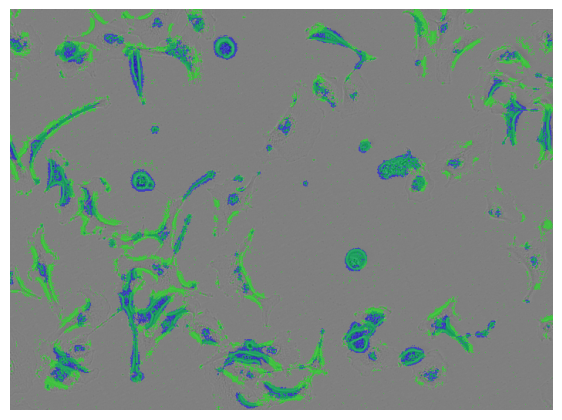

In [164]:
# inp, otsu, gt, swin,noise2s  = get_masks(439) 
show_overlay(inp, 1-otsu, 1-swin, gt, noise2s)

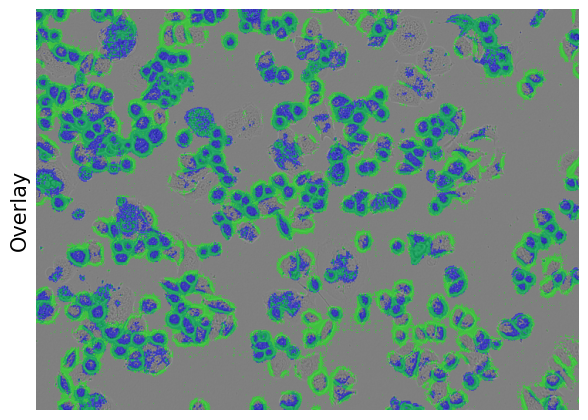

In [72]:
# inp, otsu, gt, swin, noise2s = get_masks(278) # breast cancer
show_overlay(inp, otsu, swin, gt, 1-noise2s)

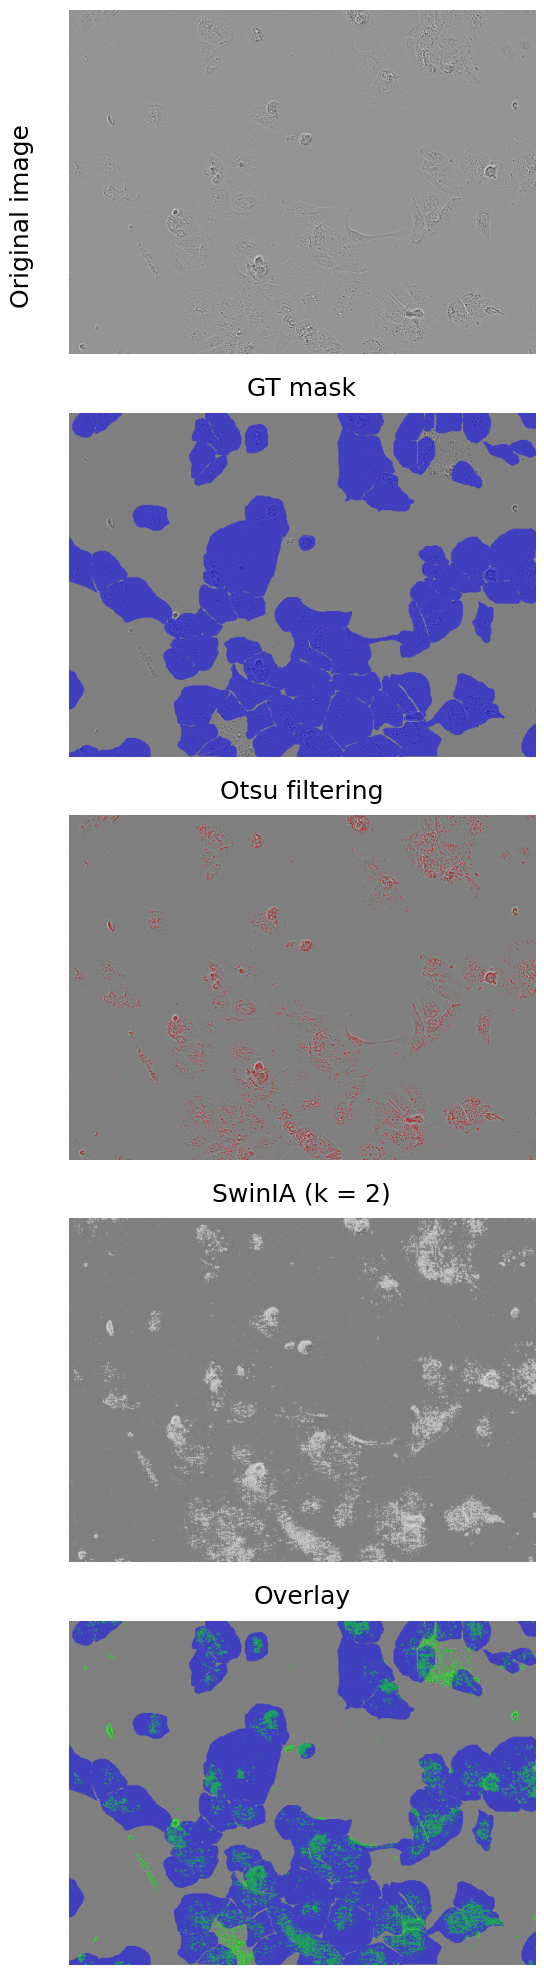

In [85]:
# inp, otsu, gt, swin = get_masks(278) # breast cancer
show_overlay(inp, 1-otsu, 1-swin, gt)

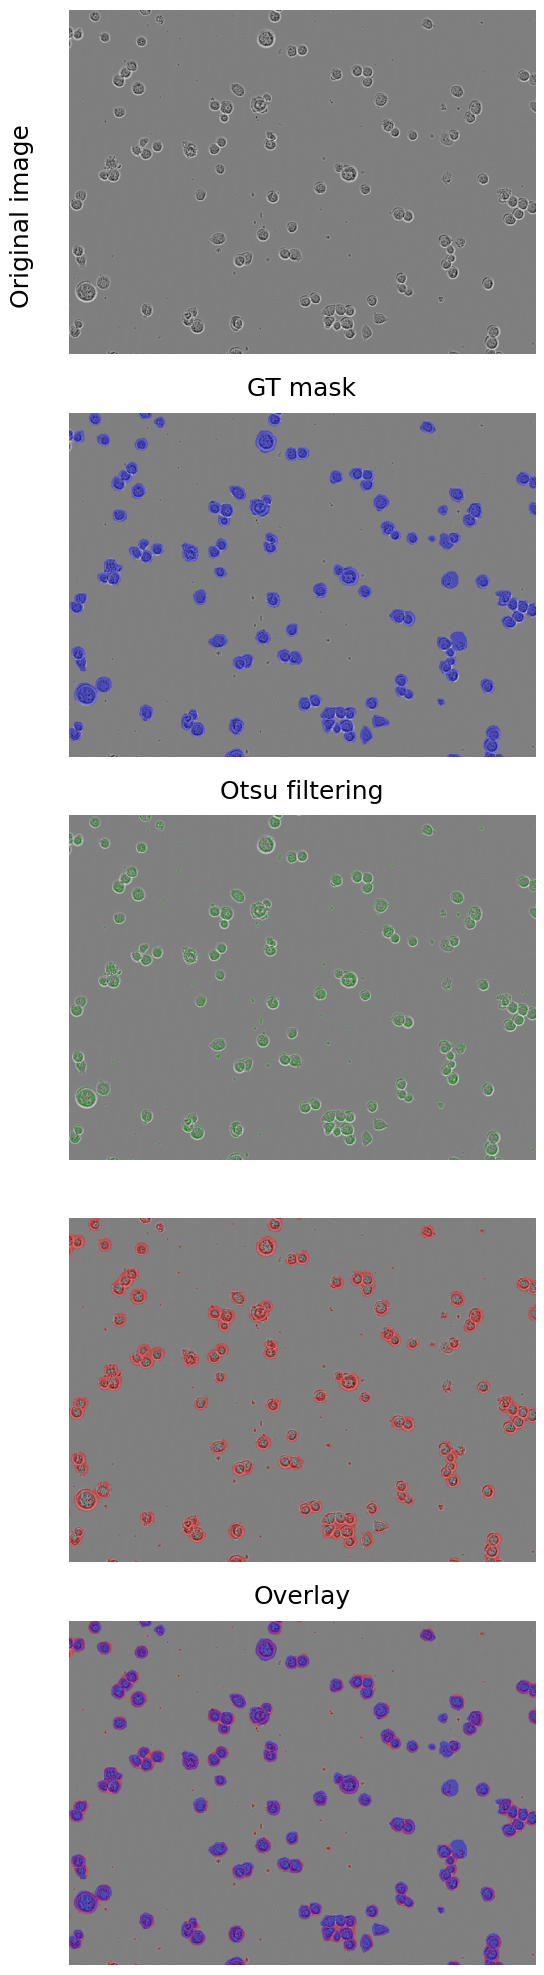

In [41]:
# inp, otsu, gt, swin = get_masks(16) #BT474, breast cancer
show_overlay(inp, 1-otsu, 1-swin, gt)

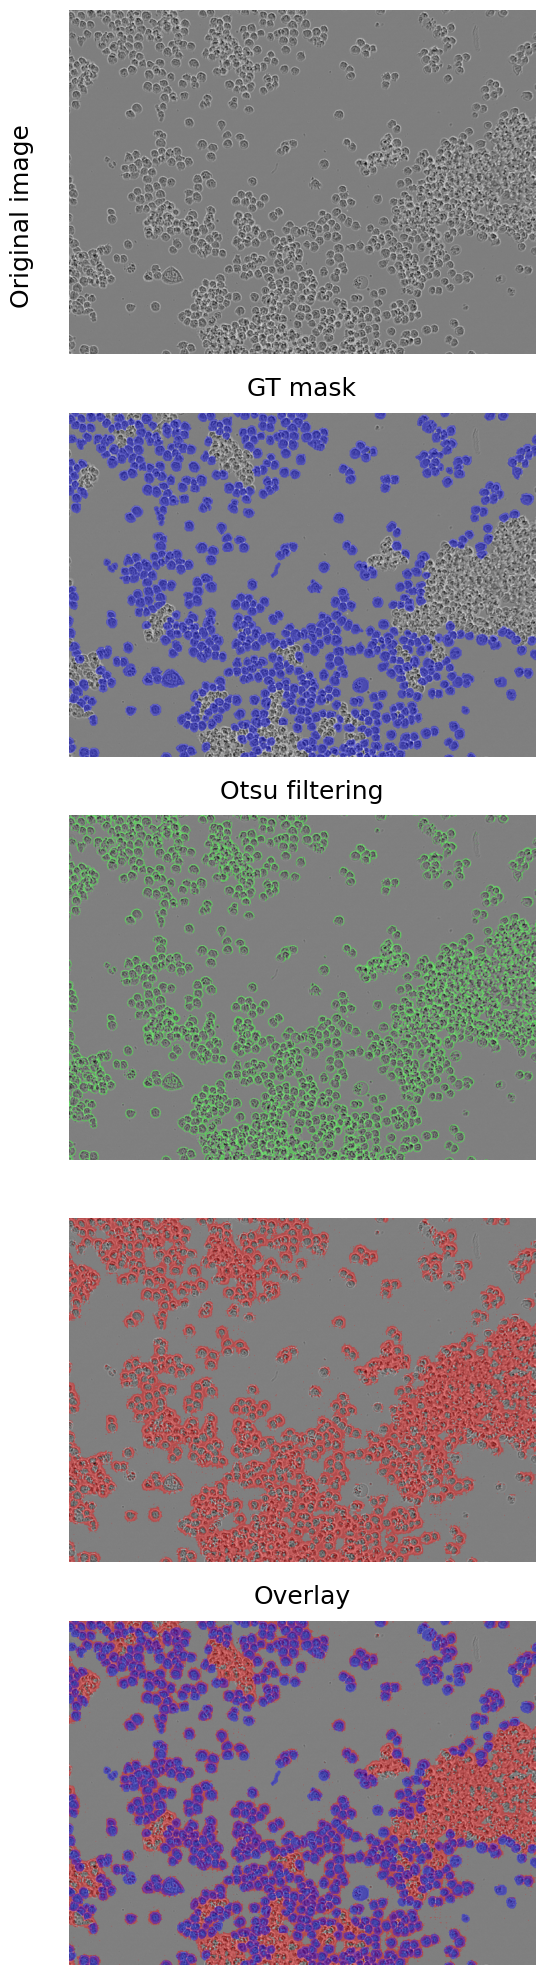

In [44]:
# inp, otsu, gt, swin = get_masks(164) #BV-2, microglial cells
show_overlay(inp, otsu, swin, gt)

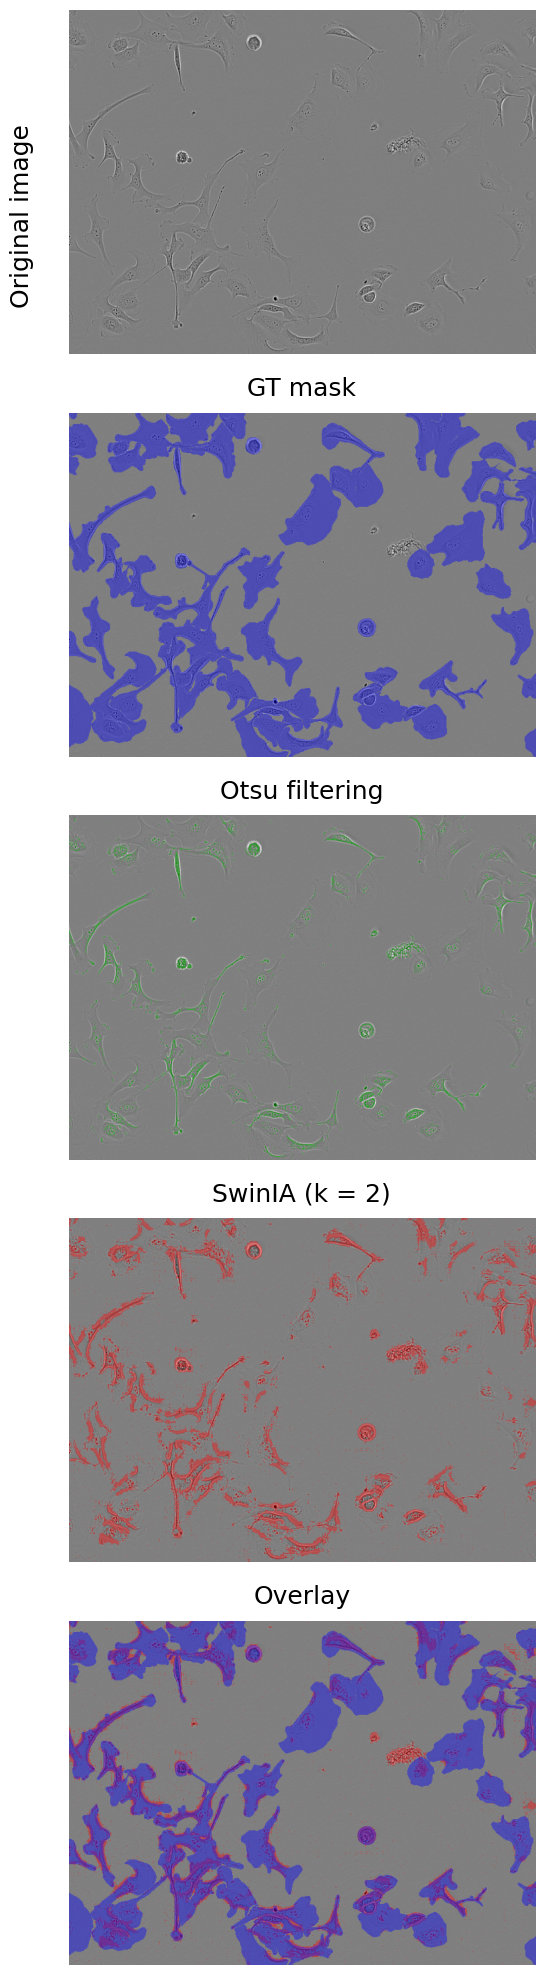

In [49]:
# inp, otsu, gt, swin = get_masks(439) #SKOV3, ovaries cancer
show_overlay(inp, 1-otsu, 1-swin, gt)

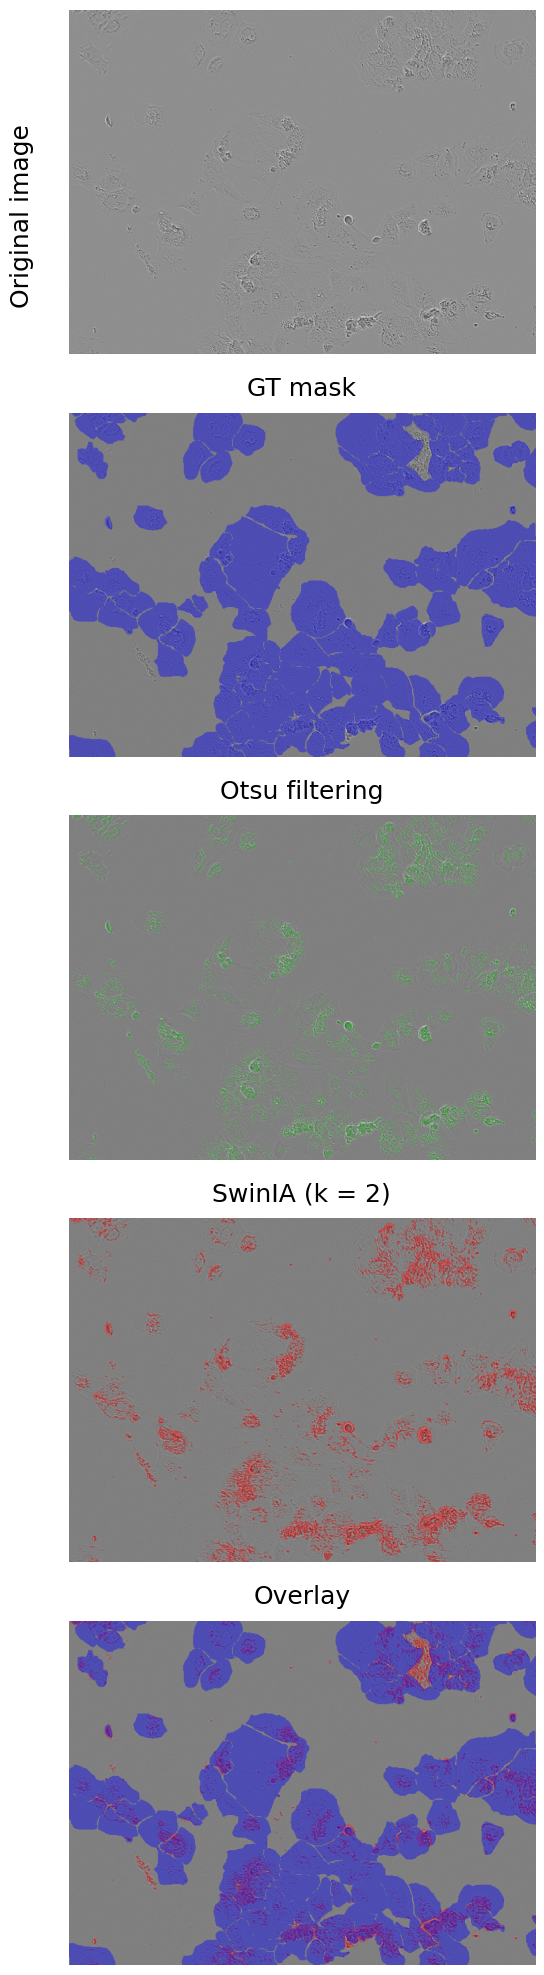

In [56]:
# inp, otsu, gt, swin = get_masks(199) #Huh7, liver cancer
show_overlay(inp, 1-otsu, 1-swin, gt)

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


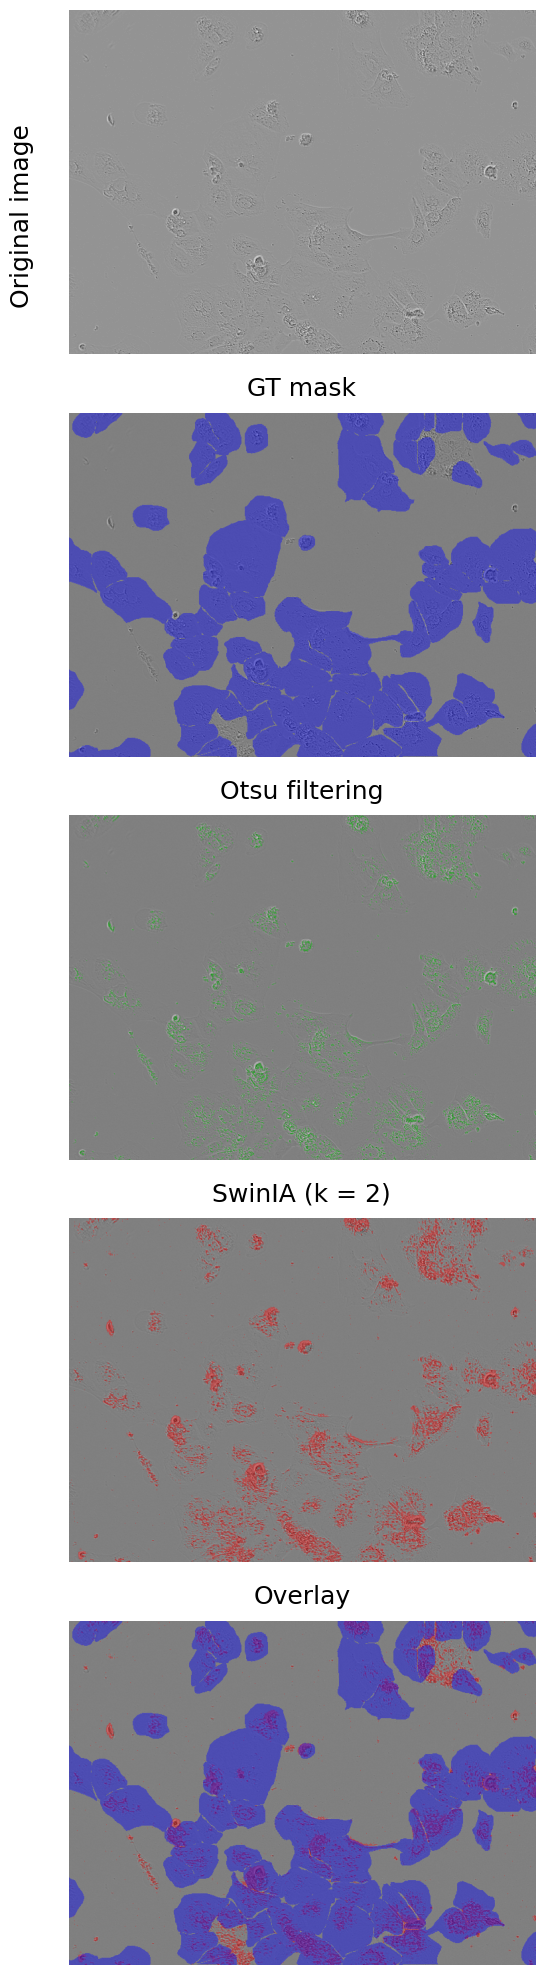

In [58]:
inp, otsu, gt, swin = get_masks(273) #Huh7, liver cancer
show_overlay(inp, 1-otsu, 1-swin, gt)

In [ ]:
clusters = []
for head in vectorized_heads:
    k_means = KMeans(n_clusters=2, n_init='auto')
    k_means.fit(head)
    clusters.append(k_means.predict(head))

In [ ]:
kernel = np.array([
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0]
], dtype=np.uint8)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for cl, ax in zip(clusters, axes.flat):
    # image = cv2.morphologyEx(cl.reshape(512, 512).astype(np.uint8), cv2.MORPH_OPEN, kernel)
    image = cl.reshape(512, 512)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.tight_layout()